In Lung Segmentation notebook, I have segmented the masks. In this notebook, I segmented the main vessels voxels with values higher than -500 HU, computed the relative vessels over lung area in % (vessel-lung area ratio) and divided the cases into 2 sub-group

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import cv2

In [2]:
#resize images
def resize_img(img):
    h, w = img.shape[0], img.shape[1]
    min_side=512
    #resize min_side 
    scale = max(w, h) / float(min_side)
    new_w, new_h = int(w/scale), int(h/scale)
    resize_img = cv2.resize(img, (new_w, new_h))
    # padding min_side * min_side
    x = (min_side-new_h) // 2
    y = (min_side-new_w) // 2
    if (min_side-new_h)%2!=0:
        pad_img = cv2.copyMakeBorder(resize_img, x+1, x, y, y, cv2.BORDER_CONSTANT, value=[0,0,0])
    elif (min_side-new_w)%2!=0:
        pad_img = cv2.copyMakeBorder(resize_img, x, x, y+1, y, cv2.BORDER_CONSTANT, value=[0,0,0])
    else:
        pad_img = cv2.copyMakeBorder(resize_img, x, x, y, y, cv2.BORDER_CONSTANT, value=[0,0,0])
    return scale,pad_img

In [3]:
df = pd.DataFrame(columns=['image_name','pixdimh','pixdimw','voxel','lung_pixels','vessel_pixels','lung_area(mm²)','vessel-lung area ratio(%)'])
mask_path = '../input/lung21-mask/'
for dirname, _, filenames in os.walk('../input/lung21/Images/'):
    for filename in filenames:
        img = nib.load(dirname+filename)
        slice_img=img.get_fdata()
        slice_img=np.rot90(slice_img, k=-1, axes=(0,1))#nibable changed orientantion 90
        scale=1
        if slice_img.shape[0] != 512 or slice_img.shape[1] != 512:
            scale,slice_img=resize_img(slice_img)
        mask = nib.load(mask_path+filename.split('.')[0]+'_mask.nii')
        hdr = mask.header
        pixdimh=hdr['pixdim'][1]#read image info
        pixdimw=hdr['pixdim'][2]
        voxel = pixdimh*pixdimw #calculate per pixel size
        img_mask=mask.get_fdata()
        lung_pixels=cv2.countNonZero(img_mask)*scale #for resized image, go back to original pixels
        lung_area = lung_pixels*voxel #calculate lung area in mm²
        slice_img[img_mask==0]=0 #put mask above the image
        slice_img[slice_img>-500]=0 #hu>-500 vessel in black
        slice_img[slice_img<=-500]=255 #other lung part in white
        vessel_pixels= lung_pixels-cv2.countNonZero(slice_img)*scale #whole lung pixels minus other lung part pixels is the vessel pixels
        ratio=vessel_pixels/lung_pixels*100  
        df = df.append({'image_name': filename,'pixdimh':pixdimh,'pixdimw':pixdimw,'voxel':voxel,'lung_pixels':lung_pixels,'vessel_pixels':vessel_pixels,'lung_area(mm²)':lung_area,'vessel-lung area ratio(%)':ratio}, ignore_index=True)

In [4]:
df.sort_values(by=['pixdimh'])

,image_name,pixdimh,pixdimw,voxel,lung_pixels,vessel_pixels,lung_area(mm²),vessel-lung area ratio(%)
2,slice_007.nii,0.488215,0.488070,0.238283,64669.4,2591.79,15409.657090,4.007750
9,slice_008.nii,0.488215,0.488070,0.238283,94816.1,4166.12,22593.108339,4.393897
14,slice_005.nii,0.533940,0.533586,0.284903,90861.8,2976.75,25886.767992,3.276131
12,slice_004.nii,0.533940,0.533586,0.284903,93527.2,3264.05,26646.149725,3.489946
19,slice_006.nii,0.554372,0.554221,0.307245,87745.6,3291.21,26959.365969,3.750856
6,slice_009.nii,0.633544,0.633996,0.401664,69139,2051.66,27770.671250,2.967437
1,slice_010.nii,0.642578,0.642578,0.412907,60550,4229,25001.497459,6.984310
7,slice_001.nii,0.677734,0.677734,0.459323,30858,1160,14173.801669,3.759155
0,slice_011.nii,0.685547,0.685547,0.469975,41244,3299,19383.629013,7.998739
11,slice_012.nii,0.685547,0.685547,0.469975,55966,5048,26302.593864,9.019762


I sorted the pixdim, the slices having the same pixdim might from the same person. 

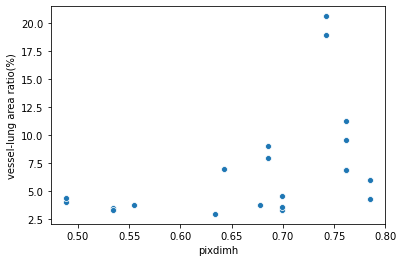

In [5]:
# Seaborn visualization library
import seaborn as sns
sns.scatterplot(df['pixdimh'],df['vessel-lung area ratio(%)'])

There are two slices having very high vessel/lung ratio, I used Kmeans to divide the whole group into Group1(normal) and Group2(abnormal)

In [6]:
from sklearn.cluster import KMeans
X= df[['pixdimh','vessel-lung area ratio(%)']]
km2 = KMeans(n_clusters=2).fit(X)
labels=km2.labels_
df['labels'] = labels

In [7]:
df.loc[df['labels'] == 1, 'Sub_group'] = 'Group1(normal)' 
df.loc[df['labels'] == 0, 'Sub_group'] = 'Group2(abnormal)'
df

,image_name,pixdimh,pixdimw,voxel,lung_pixels,vessel_pixels,lung_area(mm²),vessel-lung area ratio(%),labels,Sub_group
0,slice_011.nii,0.685547,0.685547,0.469975,41244,3299,19383.629013,7.998739,0,Group2(abnormal)
1,slice_010.nii,0.642578,0.642578,0.412907,60550,4229,25001.497459,6.984310,0,Group2(abnormal)
2,slice_007.nii,0.488215,0.488070,0.238283,64669.4,2591.79,15409.657090,4.007750,0,Group2(abnormal)
3,slice_015.nii,0.699219,0.699219,0.488907,53696,1758,26252.342773,3.273987,0,Group2(abnormal)
4,slice017.nii,0.761719,0.761719,0.580215,28568,3215,16575.595093,11.253850,0,Group2(abnormal)
5,slice_002.nii,0.785156,0.785156,0.616470,57638,3430,35532.117279,5.950935,0,Group2(abnormal)
6,slice_009.nii,0.633544,0.633996,0.401664,69139,2051.66,27770.671250,2.967437,0,Group2(abnormal)
7,slice_001.nii,0.677734,0.677734,0.459323,30858,1160,14173.801669,3.759155,0,Group2(abnormal)
8,slice021.nii,0.742188,0.742188,0.550842,22537,4269,12414.332581,18.942184,1,Group1(normal)
9,slice_008.nii,0.488215,0.488070,0.238283,94816.1,4166.12,22593.108339,4.393897,0,Group2(abnormal)


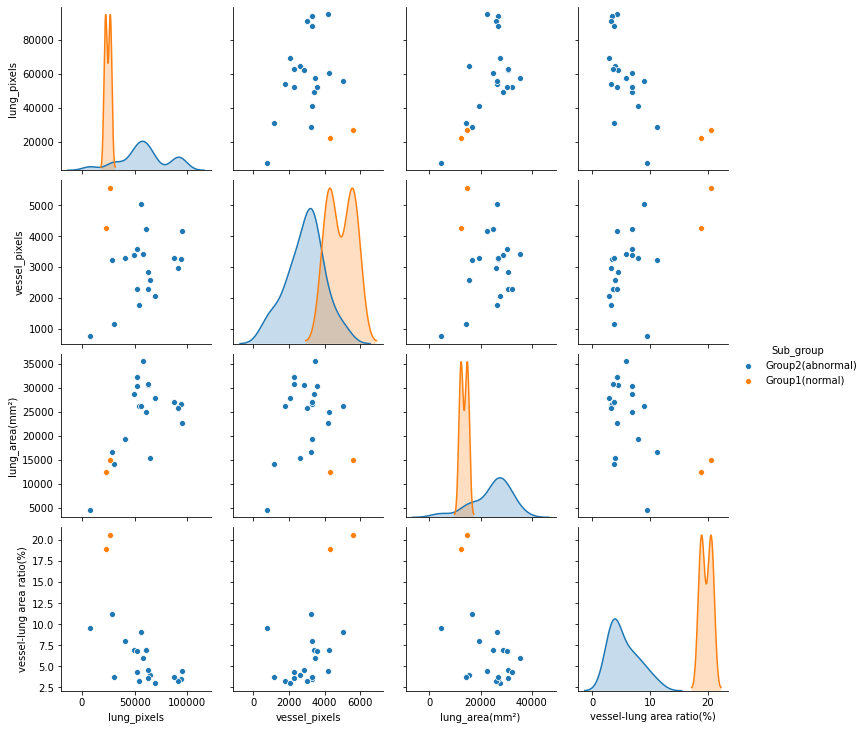

In [8]:
sns.pairplot(df[['lung_pixels','vessel_pixels','lung_area(mm²)','vessel-lung area ratio(%)','Sub_group']],hue = 'Sub_group')